In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

mnist = input_data.read_data_sets("./mnist/",one_hot=True)

print("Training set:",mnist.train.images.shape)
print("Training set labels:",mnist.train.labels.shape)
print("Dev Set(Cross Validation set):",mnist.validation.images.shape)
print("Dev Set labels:",mnist.validation.labels.shape)
print("Test Set:",mnist.test.images.shape)
print("Test Set labels:",mnist.test.labels.shape)

x_train = mnist.train.images
y_train = mnist.train.labels
x_dev = mnist.validation.images
y_dev = mnist.validation.labels
x_test = mnist.test.images
y_test = mnist.test.labels

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
Training set: (55000, 784)
Training set labels: (55000, 10)
Dev Set(Cross Validation set): (5000, 784)
Dev Set labels: (5000, 10)
Test Set: (10000, 784)
Test Set labels: (10000, 10)


In [2]:
def random_mini_batches(X, Y, mini_batch_size=64):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    m = X.shape[1]  # 训练样本个数
    mini_batches = []
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size,:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[mini_batch_size * num_complete_minibatches:,:]
        mini_batch_Y = shuffled_Y[mini_batch_size * num_complete_minibatches:,:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def parameter_init(shape):
    return tf.Variable(tf.random_normal(shape))

#定义一个函数，用于构建卷积层
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#定义一个函数，用于构建池化层
def max_pool(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

def init_parameters():
    parameters = {}
    parameters["W_conv1"] = parameter_init([5,5,1,32])
    parameters["b_conv1"] = parameter_init([32])

    parameters["W_conv2"] = parameter_init([5,5,32,64])
    parameters["b_conv2"] = parameter_init([64])

    parameters["W_fc1"] = parameter_init([7*7*64,1024])
    parameters["b_fc1"] = parameter_init([1024])

    parameters["W_out"] = parameter_init([1024,10])
    parameters["b_out"] = parameter_init([10])

    return parameters


def forward_propagation(x,parameters):
    x = tf.reshape(x,[-1,28,28,1])
    W_conv1 = parameters["W_conv1"]
    b_conv1 = parameters["b_conv1"]
    h_conv1 = tf.nn.relu(conv2d(x,W_conv1)+b_conv1)  #第一个卷积层
    h_pool1 = max_pool(h_conv1)                      #第一个池化层

    W_conv2 = parameters["W_conv2"]
    b_conv2 = parameters["b_conv2"]
    h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2)+b_conv2)  #第二个全连接层
    h_pool2 = max_pool(h_conv2)                            #第二个池化层

    W_fc1 = parameters["W_fc1"]             #第一个全连接层，256个节点
    b_fc1 = parameters["b_fc1"]
    h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])           #第二个池化层flatten to 1 dimensional vector
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)

    #keep_prob = tf.placeholder("float")
    #h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)                  #dropout层

    W_out = parameters["W_out"]
    b_out = parameters["b_out"]
    Z = tf.matmul(h_fc1,W_out) + b_out
    return Z

def compute_cost(Z, Y):
    """
    Computes the cost

    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = Z
    labels = Y

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [4]:
def tf_cnn_model(X_train,Y_train,X_test,Y_test,learning_rate=0.001,num_epochs=100,minibatch_size=64,print_cost=True):
    (m,n_x) = X_train.shape  # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[1]  # n_y : output size
    costs = []  # to keep track of the cost
    X = tf.placeholder("float", [None,n_x], name="X")
    Y = tf.placeholder("float", [None,n_y], name="Y")
    parameters = init_parameters()
    Z = forward_propagation(X,parameters)
    cost = compute_cost(Z, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.  # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 10 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Z,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
       
        return parameters

Cost after epoch 0: 519.498356
Cost after epoch 10: 5.852697
Cost after epoch 20: 0.100440
Cost after epoch 30: 0.125735


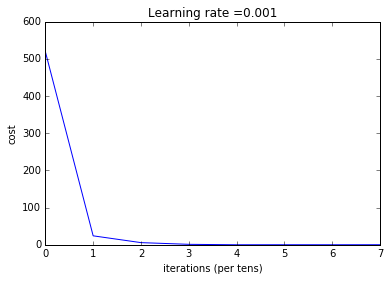

Parameters have been trained!
Test Accuracy: 0.8038


{'W_conv1': array([[[[-1.30423748, -0.21812145, -0.34049526,  0.45934623, -1.31578004,
           -0.4012326 , -0.67794859, -0.67860913, -0.09551533,  0.44291046,
            0.99578637, -0.45602691, -0.60471523,  0.38128811, -0.10409493,
           -0.64993101,  0.38739622, -0.12021308, -1.02192605,  0.34121141,
           -0.1710645 ,  0.55108005, -0.56086886, -0.90728027, -1.37572801,
            0.57125896,  0.12932123, -0.00544843,  0.29962137, -1.01984966,
           -0.5626514 , -1.40912116]],
 
         [[ 1.10349703, -1.24462664, -0.23844458,  1.02024269,  0.63445169,
           -0.93667674,  0.59208566,  0.51196712, -0.84460998,  0.85009134,
            1.21114087,  0.2725904 , -1.43338132, -0.39460966, -1.58344352,
           -0.33197072,  0.87087649, -0.98102885,  0.20169263, -0.25697815,
           -0.38124794,  1.91690409, -1.86432171, -1.2239784 , -0.32448632,
            1.6717782 ,  1.68230188, -1.22506964,  0.19751523,  1.63668072,
           -0.35887477,  0.59639281]

In [6]:
tf_cnn_model(x_train, y_train, x_test, y_test,learning_rate=0.001, num_epochs=40,
                    minibatch_size=100, print_cost=True)